# Noisy Amplifier

The most simplistic model for an amplifier is just the product of a signal with some factor (gain). But we all know, real amplifiers are noisy and nonlinear. Internal physical processes or fluctiations in the power supply produce noise and if the amplitudes get too big, we run into saturations. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection, Subsystem, Interface

from pathsim.blocks import (
    Scope, Spectrum, Amplifier, Function, Adder, WhiteNoise, 
    PinkNoise, SinusoidalSource, ButterworthLowpassFilter
    )


## Noisy Amplifier Model as Subsystem

In [5]:
# System parameters

a  = 10   # gain
fc = 1e6  # bandwidth
n  = 2    # filter order

psd_w, psd_p = 1e-9, 1e-10

In [7]:
# Internal subsystem blocks for the noisy amplifier

amp_int = Interface()
amp_wns = WhiteNoise(spectral_density=psd_w)
amp_pns = PinkNoise(spectral_density=psd_p)
amp_add = Adder()
amp_sat = Function(np.tanh)
amp_amp = Amplifier(a)
amp_flt = ButterworthLowpassFilter(fc, n)

amp_blocks = [amp_int, amp_wns, amp_pns, amp_add, amp_flt, amp_amp, amp_sat]

amp_connections = [
    Connection(amp_int, amp_add[0]),
    Connection(amp_wns, amp_add[1]),
    Connection(amp_pns, amp_add[2]),
    Connection(amp_add, amp_sat),
    Connection(amp_sat, amp_amp),
    Connection(amp_amp, amp_flt),
    Connection(amp_flt, amp_int)
    ]

AMP = Subsystem(amp_blocks, amp_connections)

## Main System (Top Level)

In [10]:
Src = SinusoidalSource(frequency=2e5, amplitude=1)
Sco = Scope(labels=["Src", "AMP"])
Spc = Spectrum(freq=np.logspace(4.1, 7, 250), labels=["Src", "AMP"])

blocks = [AMP, Src, Sco, Spc]

connections = [
    Connection(Src, AMP, Sco[0], Spc[0]),
    Connection(AMP, Sco[1], Spc[1])
    ]

In [12]:
Sim = Simulation(
    blocks, 
    connections, 
    dt=3e-8, 
    log=True
    )

2025-10-31 18:08:29,933 - INFO - LOGGING (log: True)
2025-10-31 18:08:29,934 - INFO - BLOCK (type: Subsystem, dynamic: True, events: 0)
2025-10-31 18:08:29,935 - INFO - BLOCK (type: SinusoidalSource, dynamic: False, events: 0)
2025-10-31 18:08:29,935 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-31 18:08:29,935 - INFO - BLOCK (type: Spectrum, dynamic: True, events: 0)
2025-10-31 18:08:29,936 - INFO - GRAPH (size: 4, alg. depth: 1, loop depth: 0, runtime: 0.136ms)


## Simulation

Lets run the simulation for some duration. Here 100us, 20 periods of the sinusoidal source. 

In [15]:
Sim.run(1e-4);

2025-10-31 18:08:32,444 - INFO - STARTING -> TRANSIENT (Duration: 0.00s)
2025-10-31 18:08:32,444 - INFO - TRANSIENT:   0% | elapsed: 00:00:00 (eta: --:--:--) | 0 steps (N/A steps/s)
2025-10-31 18:08:32,537 - INFO - TRANSIENT:  20% | elapsed: 00:00:00 (eta: --:--:--) | 667 steps (7145.8 steps/s)
2025-10-31 18:08:32,646 - INFO - TRANSIENT:  40% | elapsed: 00:00:00 (eta: 00:00:00) | 1334 steps (6153.8 steps/s)
2025-10-31 18:08:32,750 - INFO - TRANSIENT:  60% | elapsed: 00:00:00 (eta: 00:00:00) | 2001 steps (6443.4 steps/s)
2025-10-31 18:08:32,851 - INFO - TRANSIENT:  80% | elapsed: 00:00:00 (eta: 00:00:00) | 2667 steps (6529.2 steps/s)
2025-10-31 18:08:32,932 - INFO - TRANSIENT: 100% | elapsed: 00:00:00 (eta: 00:00:00) | 3334 steps (8276.2 steps/s)
2025-10-31 18:08:32,932 - INFO - TRANSIENT: 100% | elapsed: 00:00:00 (eta: 00:00:00) | 3334 steps (6823.3 avg steps/s)
2025-10-31 18:08:32,933 - INFO - FINISHED -> TRANSIENT (total steps: 3334, successful: 3334, runtime: 488.62 ms)


## Results

We can read the time series results and see that we get the expected amplified sinusoid. The noise parameters we chose are pretty big, so we can see the fluctuations.

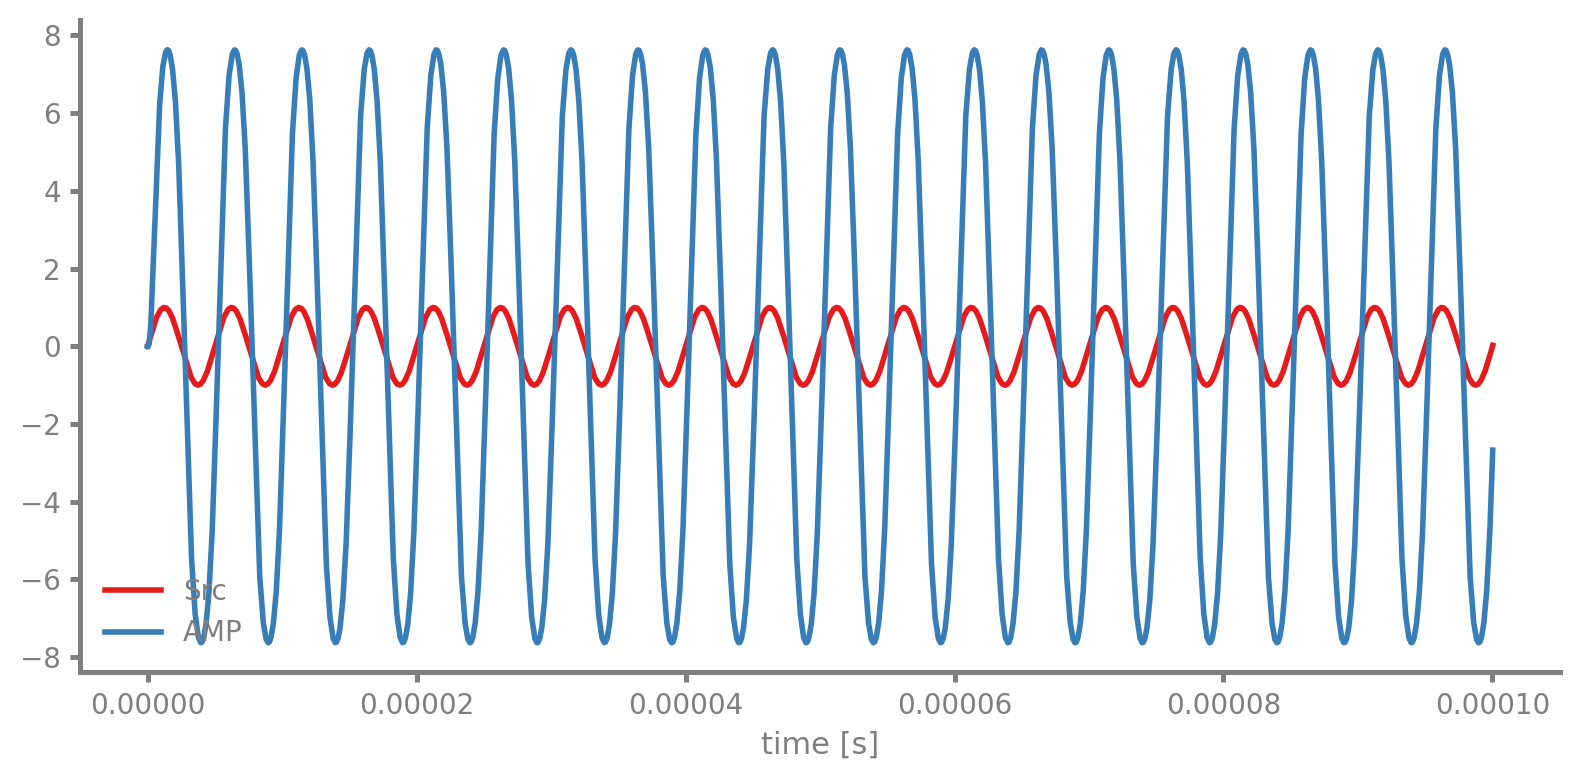

In [18]:
time, [res_src, res_amp] = Sco.read()

fig, ax = plt.subplots(nrows=1, figsize=(8, 4), tight_layout=True, dpi=200)

ax.plot(time, res_src, label=Sco.labels[0])
ax.plot(time, res_amp, label=Sco.labels[1])
ax.set_xlabel("time [s]")
ax.legend();

In the frequency domain we can see the second peak in te spectrum of the output signal. This indicates the nonlinearity.

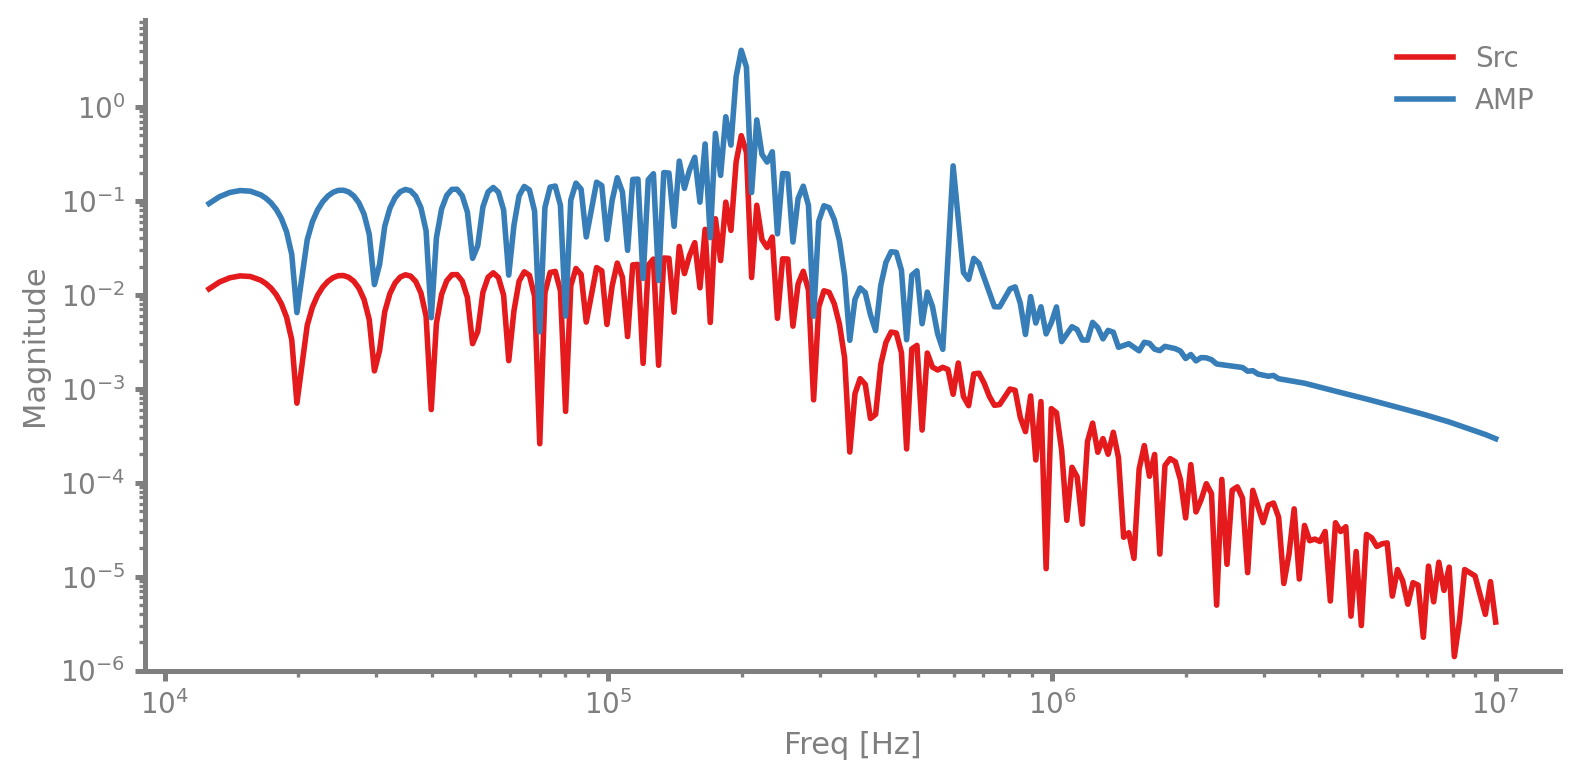

In [21]:
freq, [res_src, res_amp] = Spc.read()

fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, dpi=200)

ax.loglog(freq, abs(res_src), label=Spc.labels[0])
ax.loglog(freq, abs(res_amp), label=Spc.labels[1])

ax.set_xlabel("Freq [Hz]")
ax.set_ylabel("Magnitude")
ax.set_ylim(1e-6, None)
ax.legend();